In this code we run the Kth Nearest Neighbours (KNN) algorithm on the S&P500 returns and momentum indicators.

This is a classification problem where the output are Buy Sell or Hold. I have used the KNN algorithm as a regressor, that will give the average S&P price of its 7 closest neighbors. The identification of neighbors based on the momentum indicators I have computed. I computed Momentum indicators such as MACD, to feed the KNN algorithm that computes the Euclidean distance of data points in the training set and finds the K nearest neighbors, indicating whether to Buy Hold or Sell the underlying (S&P500).

We first compute momentum indicators (MACD), split training and testing samples, clean and format the data, compute correlations.

We will treat this as a Classification problem and use the KNN as a regressor to compute a predictive price, that will allow us to classify between Buy Hold and Sell. As a reminder on the MACD: we will compute the difference between 2 MA, using Exponentially Weighted Average of 12 an 26 days, which will be our MACD line. In order to reduce short-term noise in the price trend, we will smoothen this MACD line by taking its EWA on 9 days, allowing more reliable trade confirmation. A Bullish trend starts when the MACD line crosses above zero, and it is confirmed as a Buy Signal when the MACD line crosses above the Smoothed MACD line, and vice and versa for the Bearish trend and Sell Signal.

The KNN models is fed with our momentum indicators (30d_ma..) as its input data (X), and gives a predictive price (Y) based on the average price of the closest neighbours. The KNN computes the euclidean distance between every sample in the set and finds the K nearest neighbors in the sample based on the momentum indicators we computed.

Potential future improvments : Reduce the training sample to the current regime ; change the Momentum parameter selection of the KNN

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import warnings

warnings.filterwarnings('ignore')

In [ ]:
# Step 1. Download ticker data from Yahoo Finance
yfticker = yf.Ticker('^SPX') #Here we will use the S&P500
yfdata = yfticker.history(period='max')

# Step 2. Add momentum indicators to the model
#Using pandas functionalities here, then using directly numpy for the MACD indicator
yfdata['daily_volume'] = yfdata['Volume'].diff()
yfdata['daily_return'] = yfdata['Close'].pct_change()
yfdata['daily_range'] = yfdata['High'] - yfdata['Low']
yfdata['30d_range'] = yfdata['High'].rolling(30).max() - yfdata['Low'].rolling(30).min()
yfdata['30d_median'] = yfdata['Close'].rolling(30).median()
yfdata['30d_ma'] = yfdata['Close'].rolling(30).mean()
yfdata['30d_std'] = yfdata['Close'].rolling(30).std()


# Define EWA function without pandas, directly in numpy
def calculate_ewa(data, span):
    alpha = 2 / (span + 1)
    ewa = np.zeros(len(data))
    ewa[0] = data[0]  # Initialize the first value
    for t in range(1, len(data)):
        ewa[t] = alpha * data[t] + (1 - alpha) * ewa[t - 1]
    return ewa

# Calculate the 12-period and 26-period EWA for MACD
ewa_12 = calculate_ewa(yfdata['Close'].values, span=12)
ewa_26 = calculate_ewa(yfdata['Close'].values, span=26)

# Add MACD indicator
macd = ewa_12 - ewa_26
yfdata['macd'] = macd

# Smoothed MACD line, to reduce short-term noise and increase reliability of trend signal
yfdata['signal'] = calculate_ewa(macd, span=9)

If we want to compute the EWA and MACD with pandas:

Add MACD indicator:

yfdata['macd'] = yfdata['Close'].ewm(span=12, adjust=False).mean() - yfdata['Close'].ewm(span=26, adjust=False).mean()

Smoothed MACD line:

yfdata['signal'] = yfdata['macd'].ewm(span=9, adjust=False).mean()

In [3]:
# Step 3. Split the Data for Training and Out-of-Sample Testing, with testing on the last 365 days
#We use roughly 12 years to train our data, to stay in the same regime
train_sample = yfdata.iloc[-5000:-730, :]
test_sample = yfdata.iloc[-730:, :]

# Handle missing values in the training data
#X is the indicators matrix, Y is the price serie
missingtomean = SimpleImputer(strategy='mean') #We will input the mean when we miss data
X_train = train_sample[['daily_volume', 'daily_return', '30d_ma', 'daily_range', '30d_std','30d_range', '30d_median', 'macd', 'signal']]
X_train = pd.DataFrame(missingtomean.fit_transform(X_train), columns=X_train.columns)
y_train = train_sample['Close']
X_test = test_sample[['daily_volume', 'daily_return', '30d_ma', 'daily_range', '30d_std','30d_range', '30d_median', 'macd', 'signal']]
y_test = test_sample['Close']

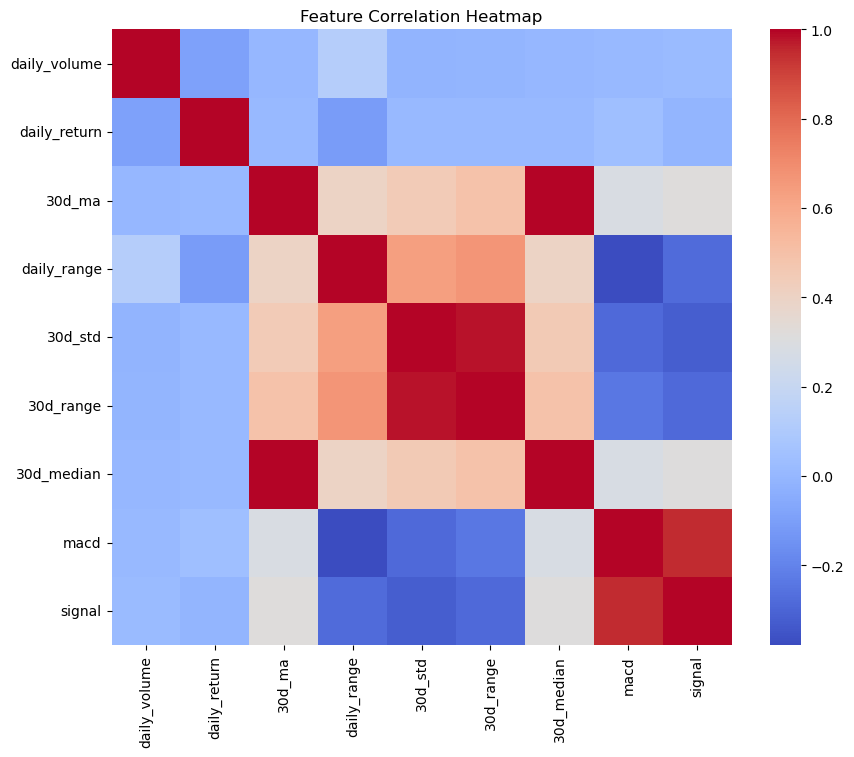

In [4]:
# Step 4. Check Correlations between Features
corr = X_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [5]:
# Step 5. Run the Kth Nearest Neighbours (KNN) Model
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(X_train, y_train)

# Step 6. Create price indicator
y_predic = knn.predict(X_test)
test_sample.loc[:, 'price_indicator'] = (y_test - y_predic) / y_test

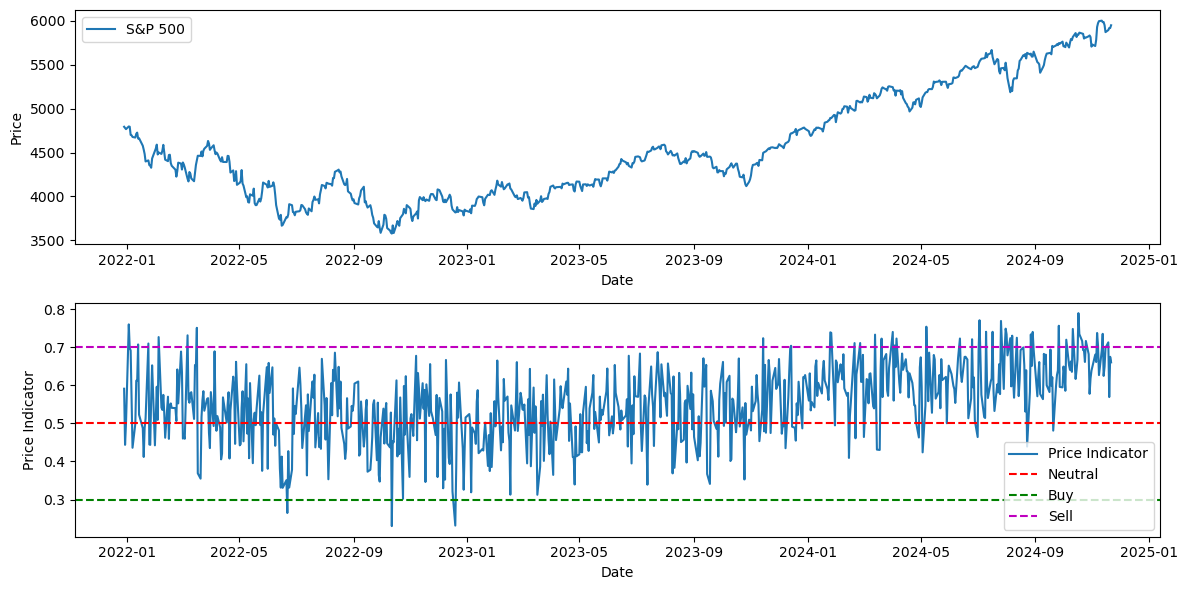

In [7]:
# Step 7. Plot price and indicator
plt.figure(figsize=(12, 6))

# Plot actual Price
plt.subplot(2, 1, 1)
plt.plot(test_sample.index, test_sample['Close'], label='S&P 500')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Plot Price Indicator
plt.subplot(2, 1, 2)
plt.plot(test_sample.index, test_sample['price_indicator'], label='Price Indicator')
plt.axhline(y=0.5, color='r', linestyle='--', label='Neutral')
plt.axhline(y=0.3, color='g', linestyle='--', label='Buy')
plt.axhline(y=0.7, color='m', linestyle='--', label='Sell')
plt.xlabel('Date')
plt.ylabel('Price Indicator')
plt.legend()

plt.tight_layout()
plt.show()